# NRC-30: NIRCam Coronagraphic Target Acquisition

## PID 1075

This activity is a two-part test of NIRCam coronagraphic target acquisition (TA). 
Both parts follow the successful completion of CAR-NIRCAM-021b (Coronagraphic Astrometric Calibration), the goal of which is a geometric distortion map of the coronagraphic FOV with RMS errors less than 3 mas in each axis.
 - **Part 1**: Determines the precise offsets required to move a star from its measured position in the target-acquisition image to the ideal location behind each occulter.
 - **Part 2**: Follows the analysis period for Part 1 and tests the implementation of the derived offsets. 
 


In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

# Program bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc
from pynrc import nrc_utils, obs_hci, nrc_hci
from pynrc.simul.ngNRC import create_level1b_FITS

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
#########################################
# Define directory paths
#########################################

import os

apt_dir       = '../../APT_output/'
# save_dir      = '/Users/jarron/NIRCam/Data/NRC_Sims/Sim_NRC30/'
save_dir      = '/home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/'

# Check that directories exist
for d in [apt_dir, save_dir]:
    if not os.path.isdir(d):
        print(f'{d} does not exist!')

## APT Inputs

In [4]:
import os
from pynrc.simul import apt, ngNRC, dms

pid_str = 'pid1075_part1'

# APT output files
xml_file      = os.path.join(apt_dir, f'{pid_str}.xml')
pointing_file = os.path.join(apt_dir, f'{pid_str}.pointing')
json_file     = os.path.join(apt_dir, f'{pid_str}.timing.json')
sm_acct_file  = os.path.join(apt_dir, f'{pid_str}.smart_accounting')

# Make sure files exist
for f in [json_file, sm_acct_file, pointing_file, xml_file]:
    print(f, os.path.isfile(f))

../../APT_output/pid1075_part1.timing.json True
../../APT_output/pid1075_part1.smart_accounting True
../../APT_output/pid1075_part1.pointing True
../../APT_output/pid1075_part1.xml True


## Targets

In [5]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# eta1 dor
# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_bright = ('HD 42525', 103, 94, 'A0V', 10325, 0.0, 4.09, 5.75, bp_k)

# References   source,     sptype, mag, band
args_faint  = ('HD 41355', 'A0V', 8.81, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = '../../votables/'

In [6]:
# Fit spectrum to SED photometry
name_bright, dist_bright, age, spt_bright, Teff_bright, feh_bright, logg_bright, mag_bright, bp_bright = args_bright
vot = votdir + name_bright.replace(' ' ,'') + '.vot'

args = (name_bright, spt_bright, mag_bright, bp_bright, vot)
kwargs = {'Teff':Teff_bright, 'metallicity':feh_bright, 'log_g':logg_bright}
src_bright = pynrc.source_spectrum(*args, **kwargs)

src_bright.fit_SED(use_err=False, robust=False, wlim=[1,5])

# Final source spectrum (pysynphot)
sp_bright = src_bright.sp_model

[0.98844468]


In [7]:
# Do the same for the reference source
name_faint, spt_faint, mag_faint, bp_faint = args_faint
vot = votdir + name_faint.replace(' ' ,'') + '.vot'

args = (name_faint, spt_faint, mag_faint, bp_faint, vot)
src_faint = pynrc.source_spectrum(*args)

src_faint.fit_SED(use_err=False, robust=False, wlim=[1,5])

# Final reference spectrum (pysynphot)
sp_faint = src_faint.sp_model

[0.96083817]


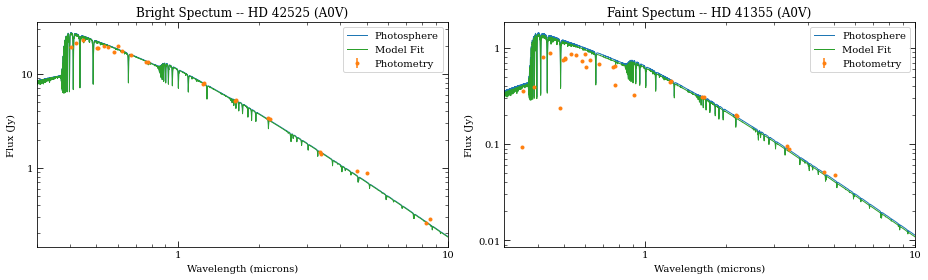

In [8]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4))
src_bright.plot_SED(xr=[0.3,10], ax=axes[0])
src_faint.plot_SED(xr=[0.3,10], ax=axes[1])

axes[0].set_title('Bright Spectum -- {} ({})'.format(src_bright.name, spt_bright))
axes[1].set_title('Faint Spectum -- {} ({})'.format(src_faint.name, spt_faint))

fig.tight_layout()

In [9]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.time import Time
from astropy.table import Table

# Initialize target dictionary
targ_dict = {}

# Dictionary keywords should match APT target names
targ_dict['HD-42525'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HD-42525', 'TargetArchiveName' : 'eta01 Dor',
    'EquatorialCoordinates' : "06 06 09.3815420998 -66 02 22.630442068",
    'RAProperMotion'  : 13.656*u.mas/u.yr, 
    'DecProperMotion' : 27.815*u.mas/u.yr, 
    'parallax' : 9.7251*u.mas, 'age_Myr' : 97,
    'params_star' : {'sp' : sp_bright},
}

# Dictionary keywords should match APT target names
targ_dict['HD-41355'] = {
    'type' : 'FixedTargetType',
    'TargetName' : 'HD-41355', 'TargetArchiveName' : 'HD 41355',
    'EquatorialCoordinates' : "05 59 39.2154186765 -65 26 49.088478043",
    'RAProperMotion'  :  1.970*u.mas/u.yr, 
    'DecProperMotion' : 21.998*u.mas/u.yr, 
    'parallax' : 3.2154*u.mas, 'age_Myr' : 1000,
    'params_star' : {'sp' : sp_bright},
}

In [11]:
# Populate coordinates and calculate distance from parallax info
for k in targ_dict.keys():
    d = targ_dict[k]
    dist = Distance(parallax=d['parallax']) if d['parallax'] is not None else None
    c = SkyCoord(d['EquatorialCoordinates'], frame='icrs', unit=(u.hourangle, u.deg),
                 pm_ra_cosdec=d['RAProperMotion'], pm_dec=d['DecProperMotion'],
                 distance=dist, obstime='J2000')
    d['sky_coords'] = c
    d['ra_J2000'], d['dec_J2000'] = (c.ra.deg, c.dec.deg)
    d['dist_pc'] = c.distance.value if dist is not None else None
    
    # Auto-generate source tables
    src_tbl = ngNRC.make_gaia_source_table(c)
    d['src_tbl'] = src_tbl if len(src_tbl)>0 else None

INFO: Query finished. [astroquery.utils.tap.core]
[astroquery:INFO] Query finished.


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

INFO: Query finished. [astroquery.utils.tap.core]
[astroquery:INFO] Query finished.


Filters:   0%|          | 0/29 [00:00<?, ?it/s]

In [32]:
sim_config = {
    # APT input files
    'json_file'     : json_file,
    'sm_acct_file'  : sm_acct_file,
    'pointing_file' : pointing_file,
    'xml_file'      : xml_file,
    # Output directory
    'save_dir'      : save_dir,
    
    # Initialize random seeds if repeatability is required
    # Create separate random number generators for dithers and noise
    'rand_seed_init'  : 1234567,
    
    # Date and time of observations
    'obs_date' : '2022-05-24', 
    'obs_time' : '12:00:00',
    # Position angle of observatory
    # User should check acceptable range in APT's Roll Analysis
    'pa_v3'    : None,
    
    # Source information
    'params_targets' : targ_dict,
    
    # PSF size information for WebbPSF_ext
    'params_webbpsf' : {'fov_pix': None, 'oversample': 2},
    # Position-dependent PSFs for convolution
    'params_psfconv' : {'npsf_per_full_fov': 9, 'osamp': 1, 'sptype': 'G0V'},
    # Wavefront error drift settings
    'params_wfedrift' : {'case': 'BOL', 'slew_init': 10, 'plot': False, 'figname': None},
    # For coronagraphic masks, sample large grid of points?
    'large_grid' : True,
    
    # Slew and dither pointing uncertainties
    'large_slew' :  10.0,     # Slew to target (mas) / Centering accuracy at TA position
    'ta_sam'     :  50.0,     # SAM movements from TA position to mask (mas)
    'std_sam'    :  10.0,     # Standard dither values (mas)
    'sgd_sam'    :  10.0,     # Small grid dithers (mas)
    
    # Type of image files to save; can be supplied directly
    'save_slope' : False,  # Save ideal noiseless slope images to FITS
    'save_dms'   : False,  # Save DMS-like ramps to FITS
    'dry_run'    : False,  # Perform a dry-run, not generating any data, just printing visit info
    
    # Noise components to include in full DMS output
    'params_noise' : {
        'include_poisson'   : True,     # Photon Noise
        'include_dark'      : True,     # Dark current
        'include_bias'      : True,     # Bias image offset
        'include_ktc'       : True,     # kTC Noise
        'include_rn'        : True,     # Read Noise
        'include_cpink'     : True,     # Correlated 1/f noise between channel
        'include_upink'     : True,     # Channel-dependent 1/f noise
        'include_acn'       : True,     # Alternating column noise
        'apply_ipc'         : True,     # Interpixel capacitance
        'apply_ppc'         : True,     # Post-pixel coupling
        'amp_crosstalk'     : True,     # Amplifier crosstalk
        'include_refoffsets': True,     # Reference offsets
        'include_refinst'   : True,     # Reference pixel instabilities
        'include_colnoise'  : True,     # Transient detector column noise
        'add_crs'           : True,     # Include cosmic ray
        'cr_model'          : 'SUNMAX', # Cosmic ray model ('SUNMAX', 'SUNMIN', or 'FLARES')
        'cr_scale'          : 1,        # Cosmic ray probabilities scaling
        'apply_nonlinearity': True,     # Apply non-linearity
        'random_nonlin'     : True,     # Add randomness to non-linearity
        'apply_flats'       : True,     # pixel-to-pixel QE variations and field-dep illum
    },
}

In [33]:
# Dry run
create_level1b_FITS(sim_config, dry_run=True, save_slope=False, save_dms=False, 
                    visit_id='001:001')

Obs Params:   0%|          | 0/92 [00:00<?, ?it/s]

Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03104 1 (-0.016, -0.040) 0.15 3470
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 1 (-0.016, -0.040) 1.22 3704
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 2 (-0.010, -0.021) 1.33 3852
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 3 (-0.040, -0.034) 1.16 4000
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 4 (-0.055, -0.051) 0.84 4148
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 5 (-0.039, -0.031) 0.51 4296
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 6 (-0.001, -0.055) 0.32 4444
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 7 (-0.007, -0.050) 0.22 4592
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 8 (-0.007, -0.037) 0.65 4740
NRCA2 NRCA2_FULL_MASK210R F210M HD-42525 001:001 03105 9 (+0.010, -0.026) 1.29 4888


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

NRCA2 NRCA2_FULL_TAMASK210R F210M HD-42525 001:001 03102 1 (+0.003, -0.016) 0.56 3210


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

NRCA2 NRCA2_TAMASK210R F210M HD-42525 001:001 02102 1 (+0.003, -0.016) 0.54 2926


In [34]:
# Slopes only
create_level1b_FITS(sim_config, dry_run=False, save_slope=True, save_dms=False, 
                    visit_id='001:001')

Obs Params:   0%|          | 0/92 [00:00<?, ?it/s]

Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03104_00001_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00001_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00002_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00003_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00004_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00005_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00006_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00007_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00008_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00009_nrca2_uncal.fits


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03102_00001_nrca2_uncal.fits


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_02102_00001_nrca2_uncal.fits


In [ ]:
# All FITS files
create_level1b_FITS(sim_config, dry_run=False, save_slope=True, save_dms=True)

Obs Params:   0%|          | 0/92 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

PPC Amps:   0%|          | 0/4 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Frames:   0%|          | 0/1 [00:00<?, ?it/s]

Exposures:   0%|          | 0/4 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075008001_02102_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/12 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/1 [00:00<?, ?it/s]

ACN:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075008001_02102_00001_nrca2_uncal.fits


Exposures:   0%|          | 0/4 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075008001_03102_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075008001_03102_00001_nrca2_uncal.fits


Exposures:   0%|          | 0/4 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075008001_03104_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075008001_03104_00001_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075008001_03105_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075008001_03105_00001_nrca2_uncal.fits


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03104_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03104_00001_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00001_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00002_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00002_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00003_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00003_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00004_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00004_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00005_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00005_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00006_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00006_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00007_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00007_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00008_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00008_nrca2_uncal.fits


Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03105_00009_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

Uncorr 1/f:   0%|          | 0/4 [00:00<?, ?it/s]

ACN:   0%|          | 0/4 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/pynrc_jw01075001001_03105_00009_nrca2_uncal.fits


Exposures:   0%|          | 0/12 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

Convolution:   0%|          | 0/1 [00:00<?, ?it/s]

  Saving: /home/jarronl/data/NIRData/NRC_Sims/Sim_NRC30/slope_jw01075001001_03102_00001_nrca2_uncal.fits


Ramps:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Non-Linearity:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
rand_seed_init = 1234567

# Read and interpret APT files
# Observation of first date, not really necessary
obs_date = '2022-05-24'  
apt_obj = apt.DMS_input(xml_file, pointing_file, json_file, sm_acct_file, 
                        obs_date=obs_date, rand_seed_init=rand_seed_init)
visits = apt_obj.program_info

In [10]:
visits

OrderedDict([('001:001',
              {'obs_num': 1,
               'visit_num': 1,
               'visit_start': 0,
               'slew_duration': 1800,
               'visit_duration': 3324,
               'exp_start_times': array([2926, 3210, 3470, 3704, 3852, 4000, 4148, 4296, 4444, 4592, 4740,
                      4888]),
               'APTTemplate': 'NircamCoron',
               'PrimaryDitherType': array(['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
                      'NONE', 'NONE', 'NONE', 'NONE'], dtype='<U4'),
               'PrimaryDithers': array(['NONE', '2', '2', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
                     dtype='<U4'),
               'DitherSize': array(['NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE', 'NONE',
                      'NONE', 'NONE', 'NONE', 'NONE'], dtype='<U4'),
               'SubpixelPositions': array(['NONE', 'NONE', 'NONE', '9', '9', '9', '9', '9', '9', '9', '9',
                      '9'], dtyp